In [59]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,Aer,execute
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
import numpy as np
import math,cmath
from scipy.linalg import circulant
from math import pi

In [144]:
# This code is taken from IBMQ website.
# source : https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [145]:
# This code is taken from IBMQ website.
# source : https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [246]:
# arbitrary array to create circulant matrix
c = [math.sin(1)/math.sqrt(2),math.sin(2)/math.sqrt(2),math.cos(1)/math.sqrt(2),math.cos(2)/math.sqrt(2)]

# arbitrary given state 'b'
b = [1,0,0,0]

#norm of c and b has to be 1
if np.linalg.norm(b).round(2)!=1 or np.linalg.norm(c).round(2)!=1:
    print("Norm of 'c' and 'b' has to be 1")
    
C = circulant(c)
C

array([[ 0.59500984, -0.29426025,  0.38205142,  0.64297038],
       [ 0.64297038,  0.59500984, -0.29426025,  0.38205142],
       [ 0.38205142,  0.64297038,  0.59500984, -0.29426025],
       [-0.29426025,  0.38205142,  0.64297038,  0.59500984]])

In [238]:
# Finding the eigen values of circuit
D = np.matmul(np.fft.ifft(np.eye(4)),np.matmul(C,np.fft.fft(np.eye(4))))
D_round = [ [round(np.real(D[j][i]),3) for i in range(len(D[j]))] for j in range(len(D))]
e_val = np.diagonal(D_round)
e_val

array([1.326, 0.213, 0.628, 0.213])

In [239]:
q = QuantumRegister(2 + 2 + 1)
c = ClassicalRegister(2 + 2 + 1)
qc = QuantumCircuit(q,c)

In [240]:
# Initialize the state
qc.initialize(b,q[:2])

In [241]:
# Apply QFT
qft(qc,2)    

In [242]:
# Oracle

theta = [math.acos(min(abs(e_val))/e_val[i]) for i in range(4)]

for i in range(4):
    
    if i==0:
        qc.x(q[0:2])
    elif i==1:
        qc.x(q[0])
    elif i==2:
        qc.x(q[1])
    
    qc.mct([q[0],q[1]],q[2],[])
    cunit = Operator([
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, math.cos(theta[i]), -math.sin(theta[i]), 0, 0],
        [0, 0, 0, 0, math.sin(theta[i]),  math.cos(theta[i]), 0, 0],
        [0, 0, 0, 0, 0, 0, math.sin(theta[i]), -math.cos(theta[i])],
        [0, 0, 0, 0, 0, 0, math.cos(theta[i]), math.sin(theta[i])]
    ])

    qc.unitary(cunit, [2,3,4])
    qc.mct([q[0],q[1]],q[2],[])

    if i==0:
        qc.x(q[0:2])
    elif i==1:
        qc.x(q[0])
    elif i==2:
        qc.x(q[1])

In [243]:
inverse_qft(qc,2)

In [244]:
qc.draw()

┌──────────────────────┐            ┌───┐   ┌───┐                      »
q170_0: ┤0                     ├──────■─────┤ H ├─X─┤ X ├──■────────────────■──»
        │  initialize(1,0,0,0) │┌───┐ │pi/2 └───┘ │ ├───┤  │                │  »
q170_1: ┤1                     ├┤ H ├─■───────────X─┤ X ├──■────────────────■──»
        └──────────────────────┘└───┘               └───┘┌─┴─┐┌──────────┐┌─┴─┐»
q170_2: ─────────────────────────────────────────────────┤ X ├┤0         ├┤ X ├»
                                                         └───┘│          │└───┘»
q170_3: ──────────────────────────────────────────────────────┤1 unitary ├─────»
                                                              │          │     »
q170_4: ──────────────────────────────────────────────────────┤2         ├─────»
                                                              └──────────┘     »
 c17_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
 c17_1: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
 c17_2: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
 c17_3: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
 c17_4: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌───┐┌───┐                      ┌───┐                                »
«q170_0: ┤ X ├┤ X ├──■────────────────■──┤ X ├──■────────────────■─────────■──»
«        ├───┤└───┘  │                │  ├───┤  │                │  ┌───┐  │  »
«q170_1: ┤ X ├───────■────────────────■──┤ X ├──■────────────────■──┤ X ├──■──»
«        └───┘     ┌─┴─┐┌──────────┐┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘┌─┴─┐»
«q170_2: ──────────┤ X ├┤0         ├┤ X ├─────┤ X ├┤0         ├┤ X ├─────┤ X ├»
«                  └───┘│          │└───┘     └───┘│          │└───┘     └───┘»
«q170_3: ───────────────┤1 unitary ├───────────────┤1 unitary ├───────────────»
«                       │          │               │          │               »
«q170_4: ───────────────┤2         ├───────────────┤2         ├───────────────»
«                       └──────────┘               └──────────┘               »
« c17_0: ═════════════════════════════════════════════════════════════════════»
«                                                                             »
« c17_1: ═════════════════════════════════════════════════════════════════════»
«                                                                             »
« c17_2: ═════════════════════════════════════════════════════════════════════»
«                                                                             »
« c17_3: ═════════════════════════════════════════════════════════════════════»
«                                                                             »
« c17_4: ═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                         ┌────────────────┐
«q170_0: ──────────────■──┤0               ├
«                      │  │  circuit273_dg │
«q170_1: ──────────────■──┤1               ├
«        ┌──────────┐┌─┴─┐└────────────────┘
«q170_2: ┤0         ├┤ X ├──────────────────
«        │          │└───┘                  
«q170_3: ┤1 unitary ├───────────────────────
«        │          │                       
«q170_4: ┤2         ├───────────────────────
«        └──────────┘                       
« c17_0: ═══════════════════════════════════
«                                           
« c17_1: ═════════════════════════════════

Correct answer: [ 0.702 -0.717  0.471  0.298]
Recieved Answer:


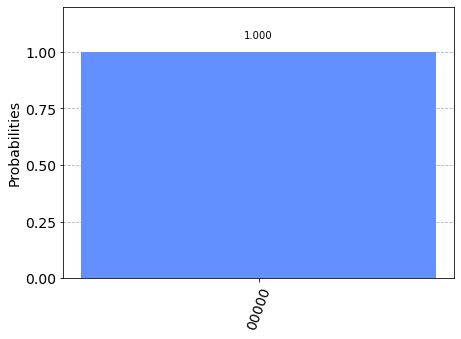

In [249]:
ans = np.matmul(np.linalg.inv(C),b).round(3)
print("Correct answer:",ans)

back=Aer.get_backend('qasm_simulator')
result=execute(qc,back,shots=1048).result()
print("Recieved Answer:")
plot_histogram(result.get_counts())